In [1]:
import os
from warnings import filterwarnings

from stop_words import get_stop_words
from stempel import StempelStemmer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import randint, uniform, loguniform
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, balanced_accuracy_score
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier, RUSBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from utils import *

In [2]:
filterwarnings("ignore")

SEED = 42
CV_SCHEME = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

## The dataset

* Loading data and labels using a custom function
* Displaying random data examples for each label
* Displaying the percentage of each class
* Initial cleaning

In [3]:
train_zip_file_path = os.path.join("data", "task_6-2.zip")
train_data_file_name = "training_set_clean_only_text.txt"
train_labels_file_name = "training_set_clean_only_tags.txt"
test_zip_file_path = os.path.join("data", "task6_test.zip")
test_data_file_path = os.path.join("Task6", "task 02", "test_set_only_text.txt")
test_labels_file_path = os.path.join("Task6", "task 02", "test_set_only_tags.txt")

train_data, train_labels = load_data_and_labels_from_zip(train_zip_file_path,
                                                         train_data_file_name,
                                                         train_labels_file_name)
test_data, test_labels = load_data_and_labels_from_zip(test_zip_file_path,
                                                       test_data_file_path,
                                                       test_labels_file_path)

In [4]:
display_samples(train_data, train_labels, n_samples=3)

Examples with label 0:
Text: @anonymized_account Oby. A zobaczymy, jak w 1/8 Portugalia z Urugwajem. Jeszcze może się okazać, że ten karny będzie wiele kosztował.
Text: Kibic @anonymized_account odpowiada @anonymized_account i @anonymized_account na krytykę Manuela Junco.\n\nhttps://t.co/3mSvihl4q8
Text: @anonymized_account Nie, będę siedział i patrzył jak zaraza pisowska się rozprzestrzenia

Examples with label 1:
Text: @anonymized_account @anonymized_account @anonymized_account Zamknij japę, bo tyle zlego co kaczystan zrobił, nasze prawnuki bede naprawiać
Text: @anonymized_account Probierz cwelu skończyłeś w burdelu!!
Text: @anonymized_account Trust me, gdyby był trochę młodszy i miał trochę więcej kasy to dawno by się jej pozbył bo traktuje ja okropnie

Examples with label 2:
Text: @anonymized_account To jest bałwochwalstwo. Kupa betonu albo metalu sprofanowana..... To jest chore.
Text: Hej TVN, będzie drugi sezon\n\"Urodzin Hitlera\"?\nZa 30 tys. można by dołożyć jakiego księdza pe

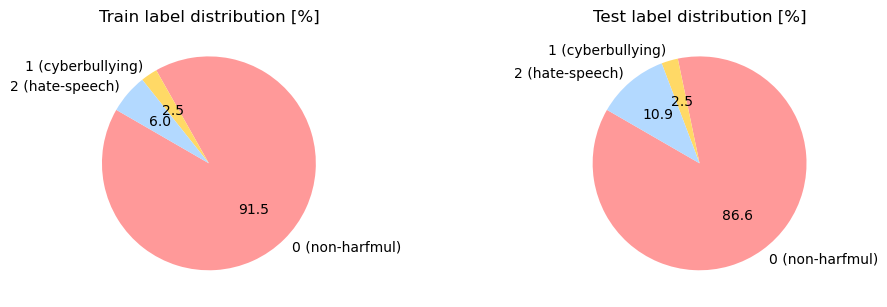

In [5]:
display_class_distribution(train_labels, test_labels)

In [6]:
len(train_labels), len(test_labels)

(10041, 1000)

Initial cleaning:

In [7]:
train_data = [text.replace("@anonymized_account", "") for text in train_data]
test_data = [text.replace("@anonymized_account", "") for text in test_data]

## Baselines

In [8]:
results = []

for model in [SVC(random_state=SEED),
              DecisionTreeClassifier(random_state=SEED),
              MultinomialNB(),
              RandomForestClassifier(random_state=SEED),
              BaggingClassifier(random_state=SEED)]:
    
    pipeline = make_pipeline(
        CountVectorizer(),
        model
    )

    result_dict = model_results(pipeline,
                                train_data, train_labels,
                                test_data, test_labels)
    results.append(result_dict)
    
pd.DataFrame(results)

,model,macroF,microF
0,SVC,0.315623,0.867
1,DecisionTreeClassifier,0.495613,0.866
2,MultinomialNB,0.326913,0.866
3,RandomForestClassifier,0.321441,0.867
4,BaggingClassifier,0.360655,0.872


## Experiments with:

* class balancing
* feature extraction method and its parameters
* model type

### Class weighting

In [9]:
# providing Polish stop words and stemming functionality as a transformer
stop_words = get_stop_words("polish")
stemmer = StempelStemmer("polish").polimorf()
stem_transformer = FunctionTransformer(lambda texts: [stemmer.stem(word) for word in texts])

Loading: 100%|██████████| 11368252/11368252 [00:05<00:00, 1990687.26bytes/s]


In [10]:
# base pipeline
pipeline = Pipeline([
    ("stemmer", stem_transformer),
    ("vectorizer", CountVectorizer()),
    ("model", SVC())
])

# preprocessing params grid for search
preprocess_grid = {
    "stemmer": [stem_transformer, "passthrough"],
    "vectorizer": [CountVectorizer(), TfidfVectorizer()],
    "vectorizer__ngram_range": [(1, 1), (1, 2)],
    "vectorizer__stop_words": [stop_words, None],
    "vectorizer__max_df": uniform(0.75, 0.25),
    "vectorizer__min_df": randint(1, 10),
    "vectorizer__max_features": [None, 1000, 2000]
}

# models param grids
class_weight = ["balanced", None,
                {0: 1, 1: 36, 2: 15},
                {0: 1, 1: 20, 2: 10}]

SVC_grid = {
    "model": [SVC(random_state=SEED)],
    "model__kernel": ["linear", "rbf"],
    "model__C": loguniform(1e-3, 1e1),
    "model__class_weight": class_weight
}
DecisionTree_grid = {
    "model": [DecisionTreeClassifier(random_state=SEED)],
    "model__min_samples_leaf": randint(1, 100),
    "model__max_depth": randint(3, 10),
    "model__max_features": uniform(0.3, 0.7),
    "model__class_weight": class_weight
}
MultiNB_grid = {
    "model": [MultinomialNB()]
}
RandomForest_grid = {
    "model": [RandomForestClassifier(random_state=SEED, n_jobs=-1)],
    "model__n_estimators": randint(100, 200),
    "model__min_samples_leaf": randint(1, 100),
    "model__max_features": uniform(0.3, 0.7),
    "model__class_weight": class_weight
}
Bagging_grid = {
    "model": [BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=SEED, n_jobs=-1)],
    "model__n_estimators": randint(100, 200),
    "model__max_samples": uniform(0.3, 0.7),
    "model__max_features": uniform(0.3, 0.7),
    "model__estimator__class_weight": class_weight
}

model_grids = [SVC_grid, DecisionTree_grid, MultiNB_grid,
               RandomForest_grid, Bagging_grid]
names = [grid["model"][0].__class__.__name__ for grid in model_grids]

results_weighting = optimize_models(names, model_grids, preprocess_grid, pipeline,
                                    train_data, train_labels, test_data, test_labels)

### Balanced ensembles

* same preprocessing grid with different models, balancing classes using random undersampling while building the ensemble, instead of class weighting as before

In [11]:
BalancedForest_grid = {
    "model": [BalancedRandomForestClassifier(random_state=SEED, n_jobs=-1)],
    "model__n_estimators": randint(100, 200),
    "model__min_samples_leaf": randint(1, 50),
    "model__max_features": uniform(0.5, 0.5),
    "model__sampling_strategy": ["all", "auto"],
    "model__bootstrap": [False],
    "model__replacement": [True, False]
}
BalancedBagging_grid = {
    "model": [BalancedBaggingClassifier(random_state=SEED, n_jobs=-1)],
    "model__n_estimators": randint(100, 200),
    "model__max_samples": uniform(0.5, 0.5),
    "model__max_features": uniform(0.5, 0.5),
    "model__sampling_strategy": ["all", "auto"],
    "model__bootstrap": [True, False]
}
RUSBoost_grid = {
    "model": [RUSBoostClassifier(random_state=SEED)],
    "model__n_estimators": randint(50, 100),
    "model__learning_rate": loguniform(1e-3, 1e0),
    "model__sampling_strategy": ["all", "auto"],
    "model__replacement": [True, False]
}

model_grids = [BalancedForest_grid, BalancedBagging_grid, RUSBoost_grid]
names = [grid["model"][0].__class__.__name__ for grid in model_grids]

results_balanced_ens = optimize_models(names, model_grids, preprocess_grid, pipeline,
                                       train_data, train_labels, test_data, test_labels)

### Results:

In [12]:
frame = pd.concat([results_weighting, results_balanced_ens])
frame.to_feather("frame.feather")
frame.set_index("model")

,cv_macroF,cv_microF,cv_balanced_acc,test_macroF,test_microF,test_balanced_acc
model,,,,,,
SVC,0.521,0.925,0.479,0.451,0.877,0.420
DecisionTreeClassifier,0.418,0.848,0.429,0.384,0.819,0.379
MultinomialNB,0.435,0.924,0.403,0.373,0.869,0.366
RandomForestClassifier,0.426,0.859,0.436,0.416,0.829,0.409
BaggingClassifier,0.461,0.908,0.433,0.384,0.856,0.379
BalancedRandomForestClassifier,0.402,0.790,0.452,0.424,0.769,0.457
BalancedBaggingClassifier,0.435,0.863,0.445,0.374,0.826,0.373
RUSBoostClassifier,0.412,0.843,0.429,0.398,0.825,0.401
